In [1]:
!pip install -q lightning
!pip install -q pytorch-metric-learning[with-hooks]
!pip install -q grad-cam


In [4]:
import numpy as np 
import pandas as pd
import os
import cv2
import random
import torchvision
import torch
import torch.nn as nn
import lightning.pytorch as pl
import scipy.io
import matplotlib.pyplot as plt

In [5]:
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks import LearningRateMonitor
from pytorch_metric_learning import losses, miners, distances, reducers
from typing import Literal

In [6]:
mat = scipy.io.loadmat('/kaggle/input/cars196-metadata/devkit/cars_train_annos.mat')
fname_to_class = {fname:cl-1 for fname, cl in zip([i[0] for i in mat['annotations'][0]['fname']], 
                                                [i[0][0] for i in mat['annotations'][0]['class']])}
cars_meta = scipy.io.loadmat('/kaggle/input/cars196-metadata/devkit/cars_meta.mat')
id_to_car = {idx: car[0] for idx, car in enumerate(cars_meta['class_names'][0])}

In [7]:
class CarDataset(Dataset):
    def __init__(self, path, car_items, transfomrs):
        super().__init__()
        self.path = path
        self.cars = car_items
        self.transform = transfomrs
    
    def __len__(self):
        return len(self.cars)
    
    def __getitem__(self, idx):
        file_name, cls_id = self.cars[idx]
        image = cv2.imread(os.path.join(self.path, file_name))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            image = self.transform(image)
        
        sample = {
            "image": image,
            "label": cls_id,
        }
        return sample

In [9]:
val_transforms =  torchvision.transforms.Compose([
            torchvision.transforms.ToPILImage(), 
            torchvision.transforms.Resize(size=(288, 288)),
            torchvision.transforms.RandomHorizontalFlip(p=0.5),
            torchvision.transforms.TrivialAugmentWide(),
            torchvision.transforms.CenterCrop(size=(288, 288)),
            torchvision.transforms.ToTensor(),  
            torchvision.transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            )
            ])

In [10]:
VAL_SIZE = 0.2
DATASET_PATH = "/kaggle/input/cars-196/cars_train/cars_train"
items = list(fname_to_class.items())
random.shuffle(items)
train_items, val_items = train_test_split(items, test_size=VAL_SIZE, shuffle=True, random_state=42)
train_dataset = CarDataset(DATASET_PATH, train_items, val_transforms)
val_dataset = CarDataset(DATASET_PATH, val_items, val_transforms)

In [11]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4, collate_fn=None, pin_memory=True, drop_last = True)
valid_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4, collate_fn=None, pin_memory=True)

In [70]:
class Embedder(pl.LightningModule):
    def __init__(self, class_dict, learning_rate, emb_size, loss_name: Literal["arc_face", "triplet_loss"]):
        super().__init__()
        self.learning_rate = learning_rate
        self.model = torchvision.models.efficientnet_b2(weights="IMAGENET1K_V1")
        self.model.classifier = torch.nn.Sequential(
                            torch.nn.Linear(in_features=1408, out_features=emb_size))
        self.loss_name = loss_name
        if self.loss_name == "triplet_loss":
            distance = distances.CosineSimilarity()
            reducer = reducers.ThresholdReducer(low=0)
            self.miner =  miners.TripletMarginMiner(margin=0.1, 
                                                    distance=distance,
                                                    type_of_triplets="semihard")
            self.triplet_loss = losses.TripletMarginLoss(margin=0.1,
                                                         distance=distance,
                                                         reducer=reducer
                                                        )
        elif self.loss_name == "arc_face":
            self.arc_face_loss = losses.ArcFaceLoss(len(class_dict), emb_size, margin=28.6, scale=64)
        else:
            raise ValueError()


    def training_step(self, batch, batch_idx):
        images = batch['image']
        labels = batch['label'].to(torch.long)
        embeddings = self.model(images)
        if self.loss_name == "triplet_loss":
            hard_pairs = self.miner(embeddings, labels)
            final_loss = self.triplet_loss(embeddings, labels, hard_pairs)
        elif self.loss_name == "arc_face":
            final_loss = self.arc_face_loss(embeddings, labels)
        else:
            raise ValueError()
            
        self.log("train_loss", final_loss, sync_dist=True)
        return final_loss

    def validation_step(self, batch, batch_idx):
        images = batch['image']
        labels = batch['label'].to(torch.long)
        embeddings = self.model(images)
        if self.loss_name == "triplet_loss":
            hard_pairs = self.miner(embeddings, labels)
            final_loss = self.triplet_loss(embeddings, labels, hard_pairs)
        elif self.loss_name == "arc_face":
            final_loss = self.arc_face_loss(embeddings, labels)
        else:
            raise ValueError()
        self.log("validation_loss", final_loss, sync_dist=True)

    def forward(self, images):
        if len(images.shape) == 4:
            preds = self.model(images) 
        else:
            preds = self.model(images.unsqueeze(0))
        return preds
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return [optimizer]

In [77]:
# %reload_ext tensorboard
# %tensorboard --logdir lightning_logs/


In [78]:
# model triplet_loss
device = "cuda" if torch.cuda.is_available() else "cpu"
pl_model = Embedder(id_to_car, 1e-4, 256, loss_name="triplet_loss")

checkpoint_callback = ModelCheckpoint(monitor='validation_loss',mode='min', save_top_k=3)
early_stopping = EarlyStopping(monitor="validation_loss", mode="min", patience=2)
lr_monitor = LearningRateMonitor(logging_interval='step')

# train model
trainer = pl.Trainer(max_epochs = 15, accelerator=device, devices = 1, callbacks=[checkpoint_callback, 
                                                                                  early_stopping,
                                                                                  lr_monitor])

trainer.fit(model=pl_model, train_dataloaders=train_loader, val_dataloaders=valid_loader)
trainer.validate(model=pl_model, dataloaders=valid_loader)

INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name         | Type               | Params
----------------------------------------------------
0 | model        | EfficientNet       | 8.1 M 
1 | miner        | TripletMarginMiner | 0     
2 | triplet_loss | TripletMarginLoss  | 0     
----------------------------------------------------
8.1 M     Trainable params
0         Non-trainable params
8.1 M     Total params
32.247    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      validation_loss      │    0.04777206853032112    │
└───────────────────────────┴───────────────────────────┘

[{'validation_loss': 0.04777206853032112}]

In [142]:
# model arc_face
device = "cuda" if torch.cuda.is_available() else "cpu"
pl_model = Embedder(id_to_car, 1e-4, 256, loss_name="arc_face")

checkpoint_callback = ModelCheckpoint(monitor='validation_loss',mode='min', save_top_k=3)
early_stopping = EarlyStopping(monitor="validation_loss", mode="min", patience=2)
lr_monitor = LearningRateMonitor(logging_interval='step')

# train model
trainer = pl.Trainer(max_epochs = 10, accelerator=device, devices = 1, callbacks=[checkpoint_callback, 
                                                                                  early_stopping,
                                                                                  lr_monitor])

trainer.fit(model=pl_model, train_dataloaders=train_loader, val_dataloaders=valid_loader)
trainer.validate(model=pl_model, dataloaders=valid_loader)


INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type         | Params
-----------------------------------------------
0 | model         | EfficientNet | 8.1 M 
1 | arc_face_loss | ArcFaceLoss  | 50.2 K
-----------------------------------------------
8.1 M     Trainable params
0         Non-trainable params
8.1 M     Total params
32.447    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=10` reached.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      validation_loss      │    19.179588317871094     │
└───────────────────────────┴───────────────────────────┘

[{'validation_loss': 19.179588317871094}]

In [143]:
import tqdm
import numpy as np
pl_model.eval()
pl_model.to(device)
np.float32

numpy.float32

In [144]:
def get_embeds(model, loader):
    embeddings = np.empty((1,256))
    labels = np.empty((1))
    for batch in tqdm.tqdm_notebook(loader):
        imgs = batch['image']
        label = batch['label']
        with torch.no_grad():
            preds = model(imgs.to(device))
        embeddings = np.concatenate([embeddings, preds.cpu().numpy()])
        labels = np.concatenate([labels, label.numpy()])
    return embeddings[1:].astype(np.float32), labels[1:].astype(int)

In [145]:
train_emb, train_labels = get_embeds(pl_model, train_loader)
val_emb, val_labels = get_embeds(pl_model, valid_loader)

/tmp/ipykernel_34/1585462233.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm.tqdm_notebook(loader):


  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

In [146]:
import faiss                   
index = faiss.IndexFlatL2(256)   
index.add(train_emb)
k = 10
D, I = index.search(val_emb, k)     # actual search
print(I[:5])                   # neighbors of the 5 first queries


[[5133 6380 4314 2930 4730 3715  822 2117 3018 3426]
 [ 454 4907 3669 5692 4220 5538 1459  113 5984  864]
 [1559 5963 1430  476 3586  598 6326 2827 6213 3562]
 [ 757 1011 2141 3938 1360 4943 3005 4446 4994  851]
 [6123  751 5496 5291 1660 1985 2587 2367 4801 2059]]


In [147]:
def get_predictions(train_labels, I):
    predictions = []
    for ind, candidats in enumerate(I):
        curr_emb = []
        for i in candidats:
            curr_emb.append(train_labels[i])
        predictions.append(curr_emb)
    return np.array(predictions, dtype=int)

def precision_at_k(predctions, gt_labels, k = 2):
    correct = []
    for predction, gt_label in zip(predctions, gt_labels):
        correct.append((predction[:k] == gt_label).mean())
    return np.mean(correct)

def recall_at_k(predctions, gt_labels, k = 2):
    correct = 0
    for predction, gt_label in zip(predctions, gt_labels):
        if gt_label in predction[:k]:
            correct += 1
    return correct / (len(gt_labels))

In [148]:
predictions = get_predictions(train_labels, I)

In [85]:
#Recall@1, Recall@5, Precision@1, Precision@5
print("triplet_loss")
Recall_1 = recall_at_k(predictions, val_labels, k=1)
Recall_5 = recall_at_k(predictions, val_labels, k=5)
Precision_1 = precision_at_k(predictions, val_labels, k=1)
Precision_5 = precision_at_k(predictions, val_labels, k=5)

print(f"Recall@1 = {Recall_1}")
print(f"Recall@5 = {Recall_5}")
print(f"Precision@1 = {Precision_1}")
print(f"Precision@5 = {Precision_5}")

triplet_loss
Recall@1 = 0.37814610190300796
Recall@5 = 0.6384284837323512
Precision@1 = 0.37814610190300796
Precision@5 = 0.29404542664211175


In [32]:
#Recall@1, Recall@5, Precision@1, Precision@5
print("arc_face")
Recall_1 = recall_at_k(predictions, val_labels, k=1)
Recall_5 = recall_at_k(predictions, val_labels, k=5)
Precision_1 = precision_at_k(predictions, val_labels, k=1)
Precision_5 = precision_at_k(predictions, val_labels, k=5)
print(f"Recall@1 = {Recall_1}")
print(f"Recall@5 = {Recall_5}")
print(f"Precision@1 = {Precision_1}")
print(f"Precision@5 = {Precision_5}")

arc_face
Recall@1 = 0.7360343769183548
Recall@5 = 0.8557397176181707
Precision@1 = 0.7360343769183548
Precision@5 = 0.699938612645795


In [88]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import numpy as np

In [161]:
transform_to_show = torchvision.transforms.Compose([
                        torchvision.transforms.ToPILImage(), 
                        torchvision.transforms.Resize(size=(288, 288)),
                        torchvision.transforms.CenterCrop(size=(288, 288)),
                        torchvision.transforms.ToTensor()
                        ])

def show_grad_cam(model, num_imgs):
    model.eval()
    cols = 3
    rows = num_imgs // cols
    fig, ax = plt.subplots(rows, cols, figsize = (15, 15))
    for idx, im_idx in enumerate(random.sample([i for i in range(len(fname_to_class))], num_imgs)):
        try:
            filename, cl_id = list(fname_to_class.items())[im_idx]
            temp_image = cv2.imread(os.path.join(DATASET_PATH, filename))
            temp_image = cv2.cvtColor(temp_image, cv2.COLOR_BGR2RGB)
            rgb_im = np.array(transform_to_show(temp_image).permute(1,2,0))
            transformed_im = val_transforms(temp_image).unsqueeze(0).to(device)
            target_layers = [model.features[-1][0]]
            cam = GradCAM(model=model, target_layers=target_layers)
            grayscale_cam = cam(input_tensor=transformed_im)
            grayscale_cam = grayscale_cam[0, :]
            visualization = show_cam_on_image(rgb_im, grayscale_cam, use_rgb=True)
            pred = id_to_car[model(transformed_im).argmax().item()]
            ax[idx//cols][idx%cols].imshow(visualization)
            ax[idx//cols][idx%cols].set_title(f'gt : {id_to_car[cl_id]} \n pred: {pred}')
            ax[idx//cols][idx%cols].axis('off')
        except:
            pass

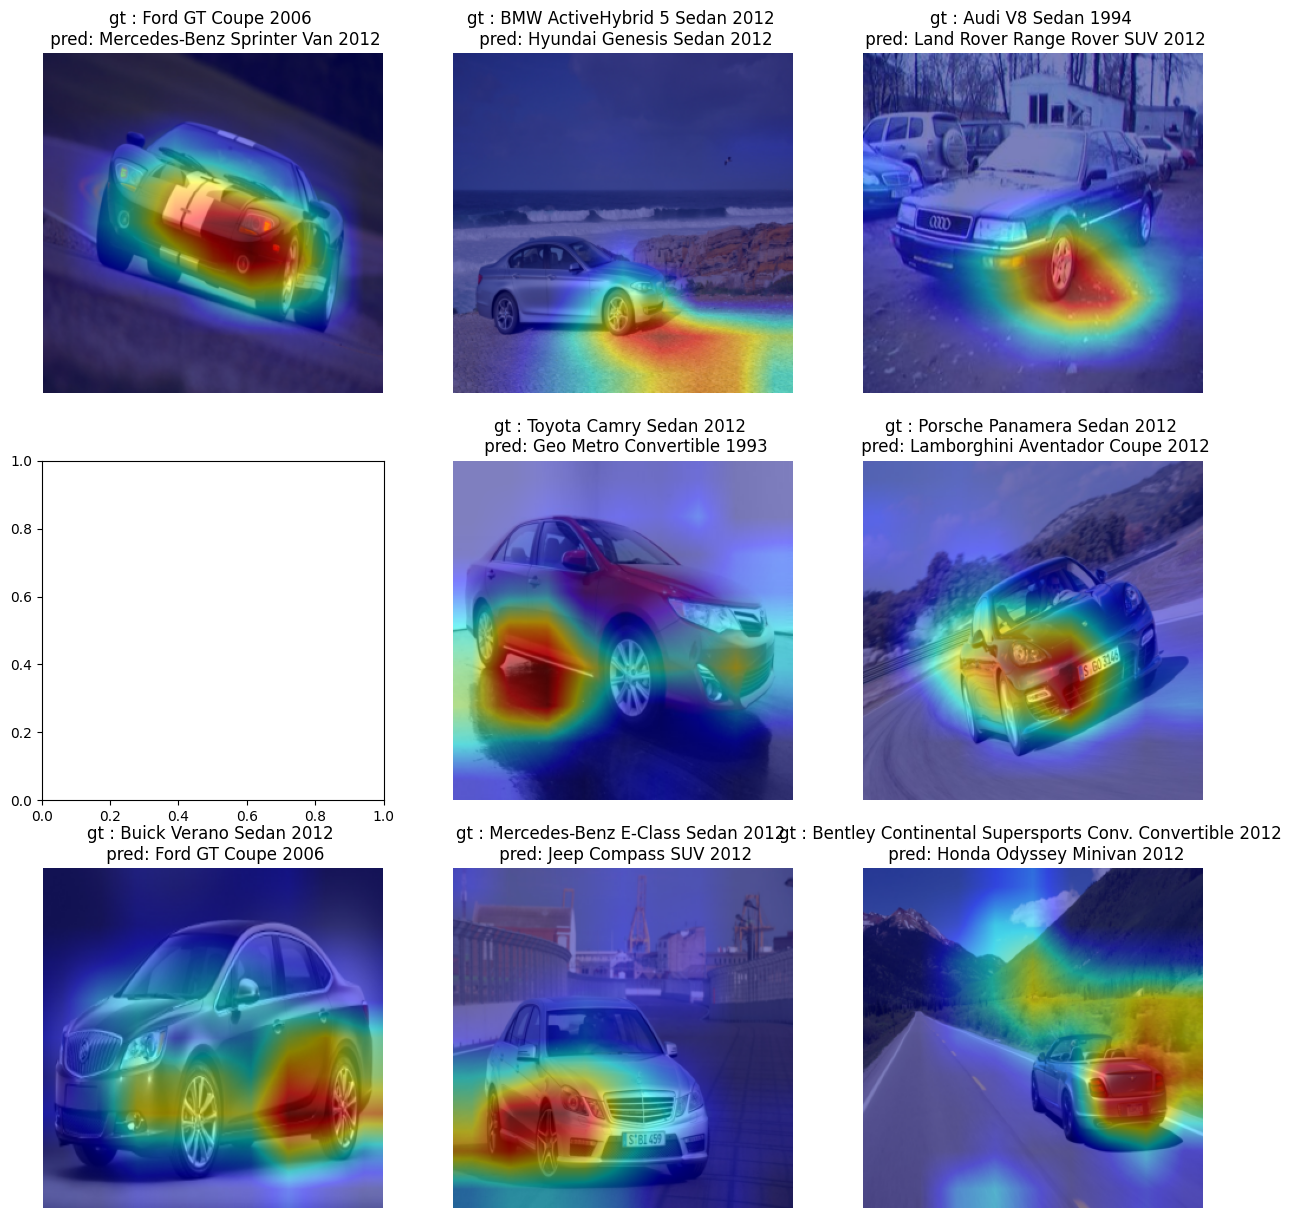

In [162]:
show_grad_cam(pl_model.model, 9)
